## 第12章 似た者同士にグループ分けしたい -クラスター分析-

質的変数ではなく, 量的変数から対象をグループ分けする分析方法

#### 12.1.2 クラスター分析の種類と分析目的
階層的クラスター分析　: 対象数が多くない場合やクラスター形成の過程に着目する場合  
非階層的クラスター分析: 対象数が多い場合やクラスター形成の過程に興味がない場合

##### 階層的クラスター分析
1. 非類似度行列の算出 
    - dist関数による距離の算出
2. デンドログラムの作成
    - hclust関数によるクラスタリング
    - as.dendrogram)で変換したオブジェクトのplot
3. クラスター数の決定
    - 自作関数による指標の算出
4. クラスター数の妥当性の確認
    - 結果をcutree&factor変換し, グループごとに基礎集計
5. クラスター数の特徴の考察

#### 12.1.3 データの読み込みと確認

In [1]:
#データの読み込み, データフレームの確認

ysi <- read.csv("https://raw.githubusercontent.com/gndb3168/Renshu_data/master/R_MA/Sec_12/vegi_nut.csv", row.names=1)
head(ysi)

,食物繊維,カリウム,ベータカロテン,ビタミンK,葉酸,ビタミンC
青ピーマン,2.3,190,400,20,26,76
赤たまねぎ,1.7,150,0,0,23,7
赤ピーマン,1.6,210,940,7,68,170
アスパラガス,1.8,270,370,43,190,15
アロエ,0.4,43,1,0,4,1
うど,1.4,220,0,2,19,4


```row.names=1```を指定することで, 元のcsvファイルの第1列目をデータフレーム(ysi)の行名に設定.

### 12.2 階層的クラスター分析の実行
**ウォード法を用いる場合, 距離は平方ユークリッド距離を用いる.**  
dist関数で引数を```method="euclidean```と指定することでユークリッド距離を算出.

#### 12.2.1 クラスター形成の実行(ウォード法に基づいた階層的クラスター分析の場合)

In [2]:
#非類似度行列の算出

DO <- dist(ysi, method="euclidean")
D <- (1/2)*DO^2    #1/2をかける理由はウォード法の理論的な理解が必須

In [3]:
#非類似度行列
D

                   青ピーマン   赤たまねぎ   赤ピーマン アスパラガス
赤たまねぎ          83385.180                                       
赤ピーマン         151384.745   457921.505                          
アスパラガス        19223.125    90551.005   184352.520             
アロエ              93661.305     5924.345   471158.720   112166.480
うど                83228.905     2464.545   456841.020    85221.580
えだまめ           137272.145   170359.945   359446.780    68261.620
オクラ              45844.645   236818.445    53276.280    48655.120
かいわれだいこん  1148211.080  1829765.020   493541.545  1202325.005
かぶ                86116.820     8834.520   455875.005    79514.545
カリフラワー        99491.180    39365.720   449391.345    78876.605
黄ピーマン          32125.000    24759.580   304556.045    43660.625
キャベツ            65297.125     7583.005   407881.520    61193.000
きゅうり             4521.220    56304.680   199557.125    16903.745
ごぼう              91802.780    15479.000   460887.905    77776.605
こまつな          3715312.580  4892596.520  240491

In [4]:
#デンドログラム作成のための下処理

ysi.out <- hclust(d=D, method="ward.D")    #引数に非類似度行列(d)とクラスター分析の種類(method)を指定する

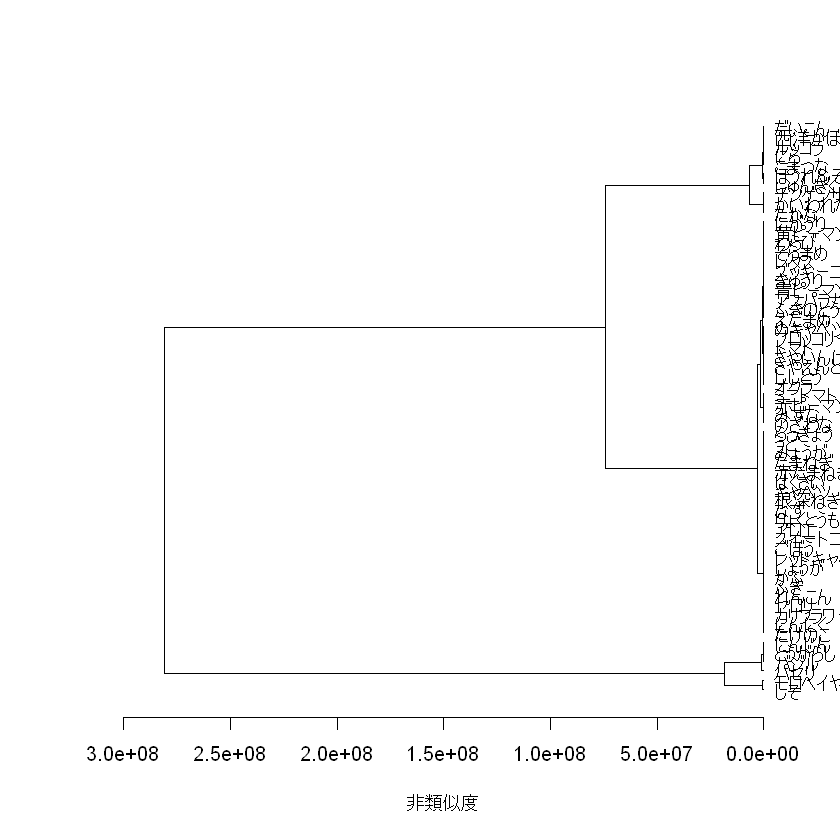

In [5]:
#デンドログラムの作成

plot(as.dendrogram(ysi.out), xlim=c(300000000, 0), xlab="非類似度", horiz=TRUE)

#### 12.2.2 デンドログラムの見方

#### 12.2.3 解釈のためのクラスター数の決定と妥当性の評価

In [6]:
#自作関数CNalidity
CNvalidity <- function(dat, clusters){
    CNvalidity0 <- function(dat, clusters, index = NULL){ #CH, H, KLの値を個別に返却する関数CNvalidity0
    # indexの指定エラー処理
    if(!is.element(index, c("CH", "H", "KL"))){
        stop("indexの指定が正しくありません")
    }
    N <- ncol(clusters) - 2 #数値を出すクラスターの数（最初と最後の列は対象外）
    d <- ncol(dat) #変数の数
    value <- data.frame(cluster.n = names(clusters)[2:(ncol(clusters)-1)], numeric(N)) #指標の値を収めるためのオブジェクト
    colnames(value)[2] <- index #指標名(CH, H, KLのどれか)をベクトルの列名に与える
    W <- function(X){ #平方和積和行列を返却する関数W
        X <- as.matrix(X)
        V <- X-(rep(1, nrow(X)) %*% t(colMeans(X))) #平均偏差化データ
        W <- t(V) %*% V
    return(W)
    }
    from <- as.numeric(names(clusters)[2]) #指標の値を算出する最初のクラスター数
    to <- as.numeric(names(clusters)[(ncol(clusters) - 1)]) #指標の値を算出する最後のクラスター数
    for(i in from:to){　#iは指標を算出するクラスター数
        # dat0-datにクラスター数iのときのクラスター,クラスター数i+1のときのクラスター,クラスター数i-1のときのクラスターを列として加えたデータフレーム
        dat0 <- data.frame(dat, cluster1 = factor(clusters[, names(clusters) == as.character(i)]), 
            cluster2 = factor(clusters[, names(clusters) == as.character(i + 1)]), 
            cluster3 = factor(clusters[, names(clusters) == as.character(i - 1)]))
        Ws1 <- by(data = dat0[, 1:d], INDICES = dat0$cluster1, FUN = W) #クラスター数iのときの各クラスターの平方和積和行列のリスト
        Ww1 <- Reduce(f = "+", Ws1) #クラスター数iのときの群内平方和積和行列(各クラスターの平方和積和行列の和)
        if(index == "CH"){
            indexname <- "Calinski & Harabasz index"
            Z  <- Reduce(f = rbind, by(data = dat0[, 1:d],INDICES = dat0$cluster1, FUN = colMeans)) #クラスター数iのときの各クラスター平均を各行に持つ行列(i×d)
            ZZ <- Z - rep(1, i) %*% t(colMeans(dat0[, 1:d])) #Zから全体平均を減じた行列(i×d)
            Nc <- diag(table(dat0$cluster1))#クラスター数iのときの各クラスターの対象数を対角要素とする対角行列
            Wb <- t(ZZ) %*% Nc %*% ZZ #クラスター数iのときの群間平方和積和行列
            indexvalue <- (sum(diag((Wb))) / (i - 1))/(sum(diag((Ww1))) / (nrow(dat0) - i)) #CHの値
        }else if(index == "H"){
            indexname <- "Hartigan index"
            Ws2 <- by(data = dat0[, 1:d], INDICES = dat0$cluster2, FUN = W) #クラスター数i+1のときの各クラスターの平方和積和行列のリスト
            Ww2 <- Reduce(f = "+", Ws2) #クラスター数i+1のときの群内平方和積和行列(各クラスターの平方和積和行列の和)
            indexvalue <- (sum(diag((Ww1))) / sum(diag((Ww2))) - 1) * (nrow(dat0) - i - 1) #Hの値
            if(i == from){ #diffHを算出するための処理（最初のクラスター数-1のときのHの値）
                Ws3 <- by(data = dat0[, 1:d], INDICES = dat0$cluster3, FUN = W)#クラスター数i-1のときの各クラスターの平方和積和行列のリスト
                Ww3 <- Reduce(f = "+", Ws3) #クラスター数i-1のときの群内平方和積和行列(各クラスターの平方和積和行列の和)		
                indexvalue_sub <- (sum(diag((Ww3))) / sum(diag((Ww1))) - 1 ) * (nrow(dat0) - (i - 1) - 1) #diffHの値
            }
        }else if(index == "KL"){
            indexname <- "Krzanowski & Lai index"
            Ws2 <- by(data = dat0[, 1:d], INDICES = dat0$cluster2, FUN = W)　#クラスター数i+1のときの各クラスターの平方和積和行列のリスト
            Ww2 <- Reduce(f = "+", Ws2) #クラスター数i+1のときの群内平方和積和行列(各クラスターの平方和積和行列の和)
            Ws3 <- by(data = dat0[, 1:d], INDICES = dat0$cluster3, FUN = W)　#クラスター数i-1のときの各クラスターの平方和積和行列のリスト
            Ww3 <- Reduce(f = "+", Ws3) #クラスター数i-1のときの群内平方和積和行列(各クラスターの平方和積和行列の和)
            DIFF1 <- sum(diag((Ww3))) * (i - 1) ^ (2 / d) - sum(diag((Ww1))) * (i) ^ (2 / d) #KLの分子
            DIFF2 <- sum(diag((Ww1))) * (i) ^ (2 / d) - sum(diag((Ww2))) * (i + 1) ^ (2 / d) #KLの分母
            indexvalue <- abs(DIFF1 / DIFF2) #KLの値
        }
        value[value[, "cluster.n"] == as.character(i), 2] <- indexvalue #指標の値の代入
    }

    if(index == "H"){
        #value-Hの値とdiffHの値を各列とするオブジェクト
        value <- data.frame(value, diffH = c(-1 * diff(c(indexvalue_sub, value[, index]))))
    }
    return(value)
    }
    #関数CNvalidity0を用いた各指標の値の算出と統合
    CHindex <- CNvalidity0(dat = dat, clusters = clusters, index = "CH") 
     Hindex <- CNvalidity0(dat = dat, clusters = clusters, index = "H") 
    KLindex <- CNvalidity0(dat = dat, clusters = clusters, index = "KL")
    indices <- merge(merge(CHindex, Hindex, by = "cluster.n", sort = FALSE), KLindex, by = "cluster.n", sort = FALSE)
    return(indices)
}

- CH: 値が大きいと, そのクラスター数が妥当であることを示唆
- H : 値が小さいと, そのクラスター数が妥当であることを示唆
- diffH: 値が大きいと, そのクラスター数が妥当であることを示唆
- KL: 値が大きいと, そのクラスター数が妥当であることを示唆

In [7]:
#クラスター数の妥当性の確認

from <- 1; to <- 11
clabel <- function(x) {factor(cutree(ysi.out, k=x))}
clusters <- data.frame(lapply(from:to, clabel))
names(clusters) <- from:to
head(clusters)

CNvalidity(dat=ysi, clusters=clusters)

,1,2,3,4,5,6,7,8,9,10,11
青ピーマン,1,1,1,1,1,1,1,1,1,1,1
赤たまねぎ,1,1,1,1,1,2,2,2,2,2,2
赤ピーマン,1,1,1,1,1,1,3,3,3,3,3
アスパラガス,1,1,1,1,1,1,1,1,1,1,1
アロエ,1,1,1,1,1,2,2,2,2,2,2
うど,1,1,1,1,1,2,2,2,2,2,2


cluster.n,CH,H,diffH,KL
2,149.3221,120.942048,28.3800902,2.9007660
3,289.5287,62.501502,58.4405462,3.5991594
4,422.1155,36.519541,25.9819607,2.6163440
5,526.5203,23.219396,13.3001451,2.1205265
6,596.0268,15.400473,7.8189234,1.8756250
7,631.7105,12.703326,2.6971466,1.4142876
8,662.8461,12.320348,0.3829785,1.1712922
9,707.7937,8.630589,3.6897591,1.6601605
10,724.2420,10.202760,-1.5721711,0.9074668


#### 12.2.4 各クラスターの特徴の把握

In [8]:
#割り当てられたクラスターの確認

(cluster <- factor(cutree(ysi.out, k=3)))

青ピーマン       赤たまねぎ       赤ピーマン     アスパラガス 
               1                1                1                1 
          アロエ             うど         えだまめ           オクラ 
               1                1                1                1 
かいわれだいこん             かぶ     カリフラワー       黄ピーマン 
               2                1                1                1 
        キャベツ         きゅうり           ごぼう         こまつな 
               1                1                1                2 
    さやいんげん     さやえんどう         ししとう             しそ 
               1                1                1                3 
      しゅんぎく         しょうが   スイートコーン       ズッキーニ 
               2                1                1                1 
    西洋かぼちゃ           セロリ         そらまめ         だいこん 
               2                1                1                2 
          たかな         たけのこ         たまねぎ     チンゲンサイ 
               2                1                1                2 
      とうがらし           トマト             なす         にがうり 
               3                1                1                1 
            にら         にんじん         にんにく         根深ねぎ 
               2                3                1                1 
        のざわな         はくさい           バジル           パセリ 
               1                1                3                3 
            ふき       ふきのとう     ブロッコリー     ほうれんそう 
               1                1                1                2 
          みずな       ミニトマト         みょうが       めキャベツ 
               1                1                1                1 
      モロヘイヤ       らっきょう りょくとうもやし         ルッコラ 
               3                1                1                2 
          レタス   レッドキャベツ         れんこん           わらび 
               1                1                1                1 
Levels: 1 2 3

In [9]:
#各クラスターの平均

by(ysi, INDICES=cluster, FUN=function(x){apply(x, 2, mean)})    #引数にデータフレーム, 群別変数, 関数(とその引数)を指定

cluster: 1
      食物繊維       カリウム ベータカロテン      ビタミンK           葉酸 
      2.972727     304.363636     280.113636      31.477273      74.522727 
     ビタミンC 
     35.250000 
------------------------------------------------------------ 
cluster: 2
      食物繊維       カリウム ベータカロテン      ビタミンK           葉酸 
          2.63         414.90        3290.00         181.90         130.40 
     ビタミンC 
         41.40 
------------------------------------------------------------ 
cluster: 3
      食物繊維       カリウム ベータカロテン      ビタミンK           葉酸 
      6.183333     585.000000    8033.333333     444.000000     118.500000 
     ビタミンC 
     58.833333 

#### 12.2.5 $z$得点化データによる分析

変数によって単位が異なる場合は, 分散の大きい変数に分析結果が影響されやすくなる.  
単位による影響を取り除くには$z$得点化したデータを用いて分析を行う.

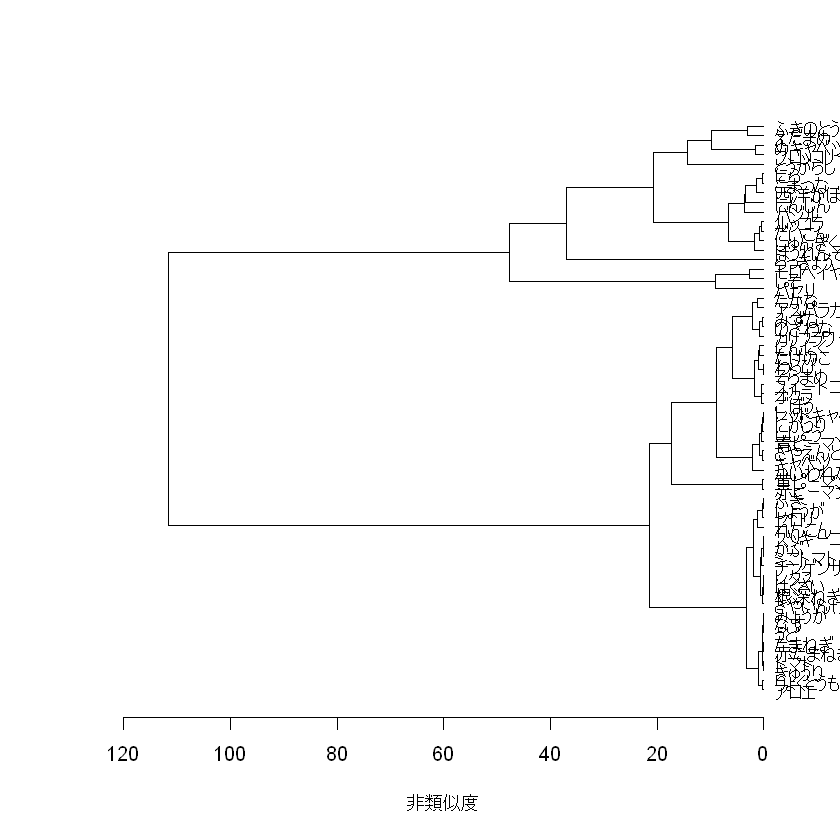

In [10]:
#z得点化データの分析

ysi.stdz <- scale(ysi)
DO.stdz <- dist(ysi.stdz, method="euclidean")
D.stdz <- (1/2)*DO.stdz^2
ysi.stdz.out <- hclust(d=D.stdz, method="ward.D")
plot(as.dendrogram(ysi.stdz.out), xlim=c(120, 0), xlab="非類似度", horiz=TRUE)

### 12.3 非階層クラスター分析の実行    -$k$平均法-

#### Hartigan&Wong(1979)の方法による非階層的クラスター分析
1. 初期クラスターの形成
2. 対象ごとの所属クラスターの更新の検討
3. 最終的なクラスターの決定

#### 12.3.1 クラスター形成の実行

In [11]:
#自作関数INTP.KM
INTP.KM <- function(dat, ncluster){ #クラスター数に応じて各クラスターの初期値となる値を返す関数
    M <- nrow(dat) #全体の対象数
    center.all <- apply(dat, 2, mean) #全体平均
    DVATmat <- as.matrix((dat - rep(1, M) %*% t(center.all))) #平均偏差化データ
    DTC0 <- diag(DVATmat %*% t(DVATmat)) #各対象と全体平均との平方ユークリッド距離
    INTP <- matrix(0, ncluster, ncol(dat)) #各行に各クラスターの初期値を収めるためのオブジェクト
    dat.ordered <- dat[order(DTC0), ] #平方ユークリッド距離の順での元のデータフレームの並べ替え
    for(i in 1:ncluster){
        INTP[i, ]<-unlist(dat.ordered[1 + (i - 1) * floor(M / ncluster), , drop = FALSE]) #初期値となる対象の観測値の代入
    }
    return(INTP)
}

In [12]:
#クラスターの形成と結果の確認

INTP <- INTP.KM(dat=ysi, ncluster=3)
(ysi.out2 <- kmeans(x=ysi, centers=INTP))

K-means clustering with 3 clusters of sizes 6, 10, 44

Cluster means:
  食物繊維 カリウム ベータカロテン ビタミンK      葉酸 ビタミンC
1 6.183333 585.0000      8033.3333 444.00000 118.50000  58.83333
2 2.630000 414.9000      3290.0000 181.90000 130.40000  41.40000
3 2.972727 304.3636       280.1136  31.47727  74.52273  35.25000

Clustering vector:
      青ピーマン       赤たまねぎ       赤ピーマン     アスパラガス 
               3                3                3                3 
          アロエ             うど         えだまめ           オクラ 
               3                3                3                3 
かいわれだいこん             かぶ     カリフラワー       黄ピーマン 
               2                3                3                3 
        キャベツ         きゅうり           ごぼう         こまつな 
               3                3                3                2 
    さやいんげん     さやえんどう         ししとう             しそ 
               3                3                3                1 
      しゅんぎく         しょうが   スイートコーン       ズッキーニ 
               2        

#### 12.3.2 クラスター数の妥当性の確認

In [13]:
#クラスター数の妥当性の確認
from <- 1; to <- 11
clabel <- function(x){
            factor(kmeans(x=ysi, centers=INTP.KM(dat=ysi, ncluster=x))$cluster)
          }
clusters <- data.frame(lapply(from:to, clabel))
names(clusters) <- from:to
CNvalidity(dat=ysi, clusters=clusters)

cluster.n,CH,H,diffH,KL
2,180.91234,97.4136495,83.4986880,3.9300807
3,289.52867,16.4241953,80.9894542,9.1739433
4,250.72480,5.8244104,10.5997849,6.7489475
5,205.69970,1.1635423,4.6608682,0.6615863
6,165.28178,1.7552231,-0.5916808,2.0382603
7,139.95366,0.5873720,1.1678511,0.5504758
8,119.11025,0.1630888,0.4242832,0.8911933
9,102.56447,0.2973253,-0.1342365,1.1959409
10,89.94534,0.1425166,0.1548087,0.9823431


- CH: 値が大きいと, そのクラスター数が妥当であることを示唆
- H : 値が小さいと, そのクラスター数が妥当であることを示唆
- diffH: 値が大きいと, そのクラスター数が妥当であることを示唆
- KL: 値が大きいと, そのクラスター数が妥当であることを示唆

#### 12.3.3 $z$得点化データによる分析

In [14]:
#z得点化データによる分析

INTP.stdz <- INTP.KM(dat=ysi.stdz, ncluster=3)
(ysi.stdz.out2 <- kmeans(x=ysi.stdz, centers=INTP.stdz))

K-means clustering with 3 clusters of sizes 16, 41, 3

Cluster means:
    食物繊維   カリウム ベータカロテン  ビタミンK       葉酸  ビタミンC
1  0.7065542  0.8458100      0.4039716  0.3518301  0.8740564  0.3473846
2 -0.3606420 -0.4630383     -0.3839680 -0.4056681 -0.4496996 -0.1918954
3  1.1604856  1.8172040      3.0930473  3.6677035  1.4842601  0.7698520

Clustering vector:
      青ピーマン       赤たまねぎ       赤ピーマン     アスパラガス 
               2                2                2                2 
          アロエ             うど         えだまめ           オクラ 
               2                2                1                2 
かいわれだいこん             かぶ     カリフラワー       黄ピーマン 
               2                2                2                2 
        キャベツ         きゅうり           ごぼう         こまつな 
               2                2                2                1 
    さやいんげん     さやえんどう         ししとう             しそ 
               2                2                2                3 
      しゅんぎく         しょうが   スイートコーン       ズッキ

### 12.4 報告例

60種類の野菜を「食物繊維」「カリウム」「βカロテン」「ビタミンK」「葉酸」「ビタミンC」の栄養素の点から分類した. 分類には階層的クラスター分析(ウォード法), 対象間の非類似度は平方ユークリッド距離の1/2倍)を用いた. デンドログラムを観察したところ, 3クラスターでの解釈可能性の高さが示唆され, Cali&nacute;ski & Harabasz(1974), Hartigan(1975), Krzanowski & Lai(1988)の指標からも3クラスターの妥当性が支持された.  
各クラスターのクラスター平均から考察すると, クラスター3は全ての栄養素を多く含む"スーパー野菜", クラスター2は他の栄養素に比べて葉酸を多く含む"葉酸野菜"のクラスターといえる. また, クラスター1は栄養素について特徴的なことはない"平凡野菜"のクラスターであった.